## Libraries

In [1]:
## libraries
import sys
import os
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re

%matplotlib inline

# to import Database class from data_collection folder
module_path = os.path.abspath(os.path.join('..')+'/data_collection')
if module_path not in sys.path:
    sys.path.append(module_path)

# now that the folder is in the path, ../data_collection/database.py can be imported
from database import Database


ModuleNotFoundError: No module named 'seaborn'

### Import data

In [ ]:
db = Database()

# get all reviews
reviews_sql = '''SELECT * FROM reviews'''
reviews_df = db.select_df(reviews_sql)
reviews_df.shape #(5092, 4)

# get yelp businesses
yelp_sql = '''SELECT * FROM businesses WHERE url LIKE '%yelp%' '''
yelp_df = db.select_df(yelp_sql)
yelp_df.shape #(4098, 6)
%store yelp_df

# select only yelp reviews
yelp_reviews_df = reviews_df[reviews_df.restaurant_id.isin(yelp_df.platform_id)]
yelp_reviews_df.shape #(5092, 4)

# number of yelp businesses with reviews
reviews_df.restaurant_id.nunique() # 838

# add column with num of scraped reviews per business
counts = reviews_df.restaurant_id.value_counts()
yelp_df = yelp_df.assign(halal_review_count=yelp_df.platform_id.map(dict(zip(counts.index, counts.values))))
yelp_df.halal_review_count = yelp_df.halal_review_count.fillna(0)

## Data summary:
- Total of 4098 businesses from yelp
- 838 had reviews that included the word 'halal'
- Total of 5092 review texts
- dist plot of num of reviews per restaurant

## Places scraped

In [ ]:


# frequency of cities from address column
places = yelp_df['address'].apply(lambda x: x.split(',')[1]).value_counts()
places = places[ places >= 40] # arbitrary threshold just for plotting
g = sns.barplot(x=places.index, y=places.values)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

- there seems to be a good amount of data from outside areas of interest (Chicago, SF, Washington)
- check how many include the string 'NY'?

In [ ]:
# barplot of yelp addresses that include "NY" or not
ny_or_not = yelp_df['address'].apply(lambda x: 'NY' in x)
ny_or_not_count = [sum(ny_or_not), len(ny_or_not)-sum(ny_or_not)]
g = sns.barplot(x=['NY','Other'], y=ny_or_not_count)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

- Yelp API search parameters should be updated to exclude should results.
- Reviews from off-target can easily be removed from database by restaurant_id

### Let's see what are most common words in the reviews

In [ ]:
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# convert the text to lower case
yelp_reviews_df['review_text'] = yelp_reviews_df['review_text'].str.lower()

# splitting and removing punctuations
all_text = yelp_reviews_df['review_text'].str.replace('\n', ' ').str.split()
all_text_cleaned = []
for text in all_text:
    text = [x.strip(string.punctuation) for x in text]
    all_text_cleaned.append(text)

reviews_text = [' '.join(text) for text in all_text_cleaned]
final_reviews_text = ' '.join(reviews_text)
%store final_reviews_text

# generate word cloud and plot
wc = WordCloud(background_color="white", collocations = False, width=800, height=400).generate(final_reviews_text)
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


- 'halal' is obviously the most common word
### What are most common words after 'halal'?

In [ ]:
# add 'halal' to stopwords so it's ignored
stopwords = set(STOPWORDS)
stopwords.update(["halal"])

wc = WordCloud(stopwords=stopwords, background_color="white", collocations = False, width=800, height=400).generate(final_reviews_text)
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

- look into inclusion/ exclusion distribution of certain words

### What are the most common words before/ after 'halal' in reviews text?

In [1]:
# run under Spacy_env
import spacy
import pandas as pd

nlp = spacy.load("en_core_web_sm")

# used preproccesed text data from wordcloud. Should consider using Spacy's proprocessing
%store -r final_reviews_text
reviews_string = nlp(final_reviews_text[:50000])

def get_token_sent(token):
    token_span = token.doc[token.i:token.i+1]
    return token_span.sent

def get_positions_df(my_string):
    # collect data into pandas Dataframe
    df = pd.DataFrame(columns=['sentence', 'index', '2-', '1-', '1+', '2+',
                              '2-pos', '1-pos', '1+pos', '2+pos', '2-ent', '1-ent', '1+ent', '2+ent'])

    for token in my_string:
        if token.text == 'halal':
            row = {
                'sentence' : get_token_sent(my_string[token.i]),
                'index' : token.i,
                '2-' : my_string[token.i-2].lemma_,
                '1-' : my_string[token.i-1].lemma_,
                '1+' : my_string[token.i+1].lemma_,
                '2+' : my_string[token.i+2].lemma_,
                '2-pos' : my_string[token.i-2].pos_,
                '1-pos' : my_string[token.i-1].pos_,
                '1+pos' : my_string[token.i+1].pos_,
                '2+pos' : my_string[token.i+2].pos_,
                '2-ent' : spacy.explain(my_string[token.i-2].tag_),
                '1-ent' : spacy.explain(my_string[token.i-1].tag_),
                '1+ent' : spacy.explain(my_string[token.i+1].tag_),
                '2+ent' : spacy.explain(my_string[token.i+2].tag_),
            }
            df = df.append(row, ignore_index=True)
    return df

In [2]:
positions_df = get_positions_df(reviews_string)
positions_df.head()

,sentence,index,2-,1-,1+,2+,2-pos,1-pos,1+pos,2+pos,2-ent,1-ent,1+ent,2+ent
0,"(but, i, suppose, that, would, violate, this, ...",105,establishment,be,bottom,line,NOUN,AUX,ADJ,NOUN,"noun, singular or mass","verb, gerund or present participle",adjective,"noun, singular or mass"
1,"(has, a, delicious, menu, and, the, service, i...",231,-PRON-,serve,meat,i,PRON,VERB,NOUN,PRON,"pronoun, personal","verb, non-3rd person singular present","noun, singular or mass","pronoun, personal"
2,"(very, good, halal, establishment, peri, peri,...",306,very,good,establishment,peri,ADV,ADJ,NOUN,PROPN,adverb,adjective,"noun, singular or mass","noun, proper singular"
3,"(but, it, comes, very, close, to, being, that,...",380,the,good,food,in,DET,ADJ,NOUN,ADP,determiner,"adjective, superlative","noun, singular or mass","conjunction, subordinating or preposition"
4,"(but, not, something, i, 'd, be, trekking, out...",474,who,eat,meat,,PRON,VERB,NOUN,SPACE,"wh-pronoun, personal","verb, non-3rd person singular present","noun, singular or mass",None


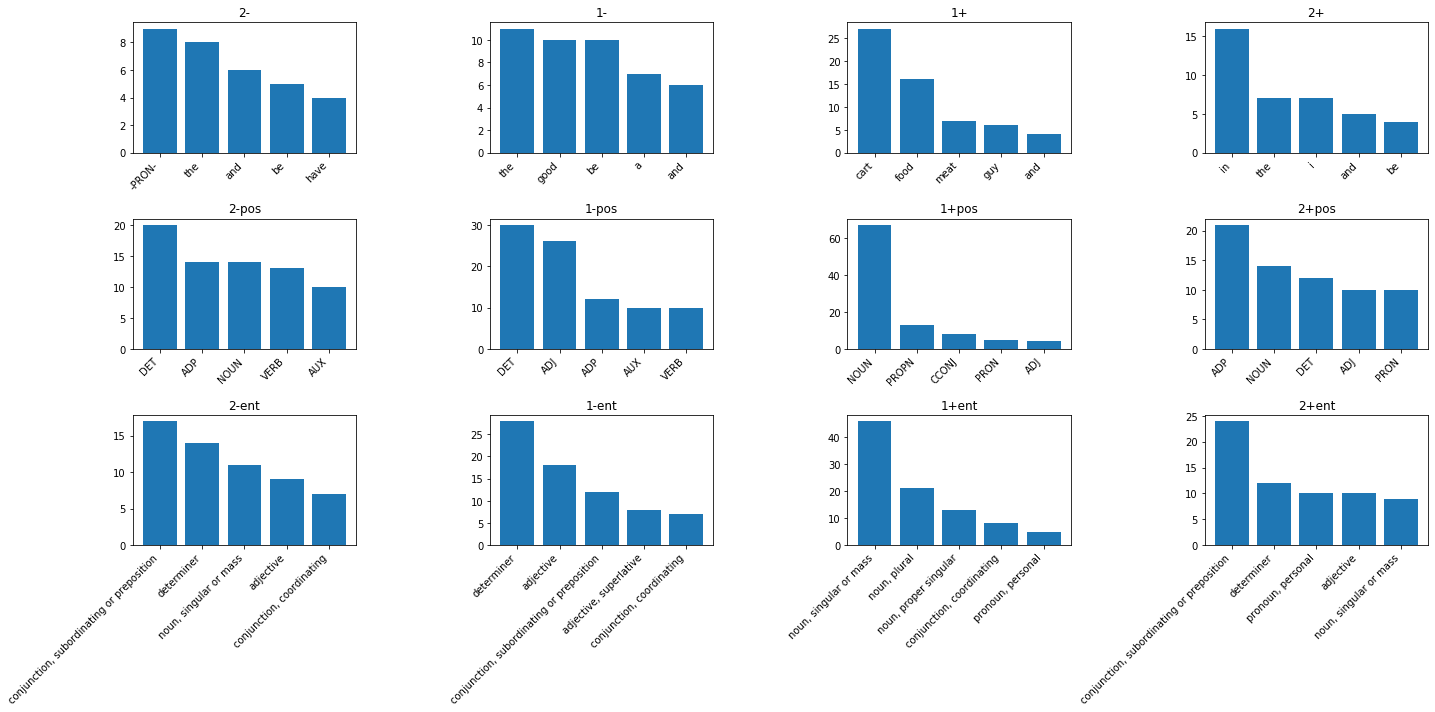

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
columns = positions_df.columns[2:].to_list()

for i, column in enumerate(columns):
    labels = positions_df[column].value_counts()[:5].index 
    values = positions_df[column].value_counts()[:5]
    ax = fig.add_subplot(3,4,i+1)
    ax.bar(labels, values)
    ax.set_title(column)
    ax.set_xticklabels(labels , rotation=45, horizontalalignment='right')
    
plt.tight_layout()
plt.show()

In [12]:
positions_df.columns

Index(['sentence', 'index', '2-', '1-', '1+', '2+', '2-pos', '1-pos', '1+pos',
       '2+pos', '2-ent', '1-ent', '1+ent', '2+ent'],
      dtype='object')

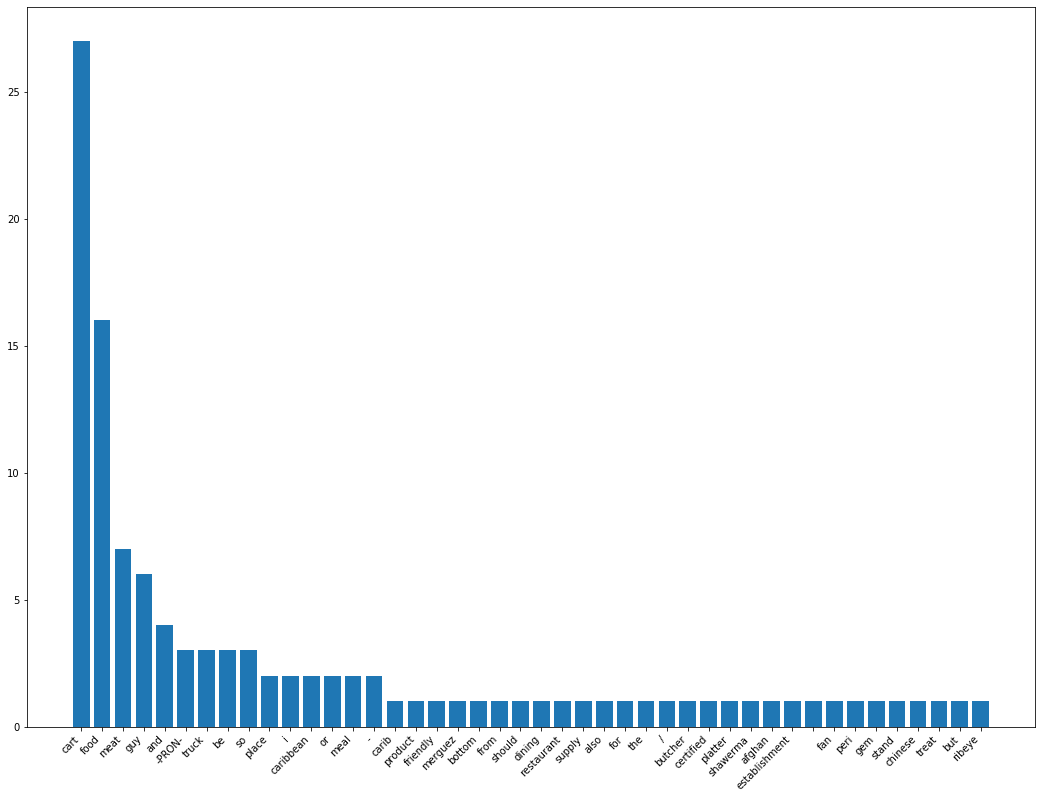

In [15]:
labels = positions_df['1+'].value_counts().index 
values = positions_df['1+'].value_counts()

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,10))
ax = fig.add_axes([0,0,1,1])

ax.bar(labels,values)
ax.set_xticklabels(labels , rotation=45, horizontalalignment='right')
plt.show()

In [16]:
sum(positions_df['1+'].value_counts())

113

### Features to consider
- Need entity of 'Halal' to distinguish if it's adjective (Halal meat) vs. noun (Halal guys/food)
- When 'Halal' is adjective, need sentiment of the sentence. Negative qualifiers. Capture negators
- Wordcloud 

## Let's compare the two lists of halal restaurants

In [ ]:
# switch back to sm-project env
import seaborn as sns 

target_df = pd.read_csv('/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/data/data_collection/target_list.csv')
target_match = target_df['validated_address'][target_df.source == 'Zabiha'].isin(target_df['validated_address'][target_df.source == 'Zomato'])
target_match_count = [sum(target_match), len(target_match)-sum(target_match)]
g = sns.barplot(x=['Zabiha & Zomato','Zabiha Only'], y=target_match_count)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

## How many of the target restaurants are in the yelp list?

In [ ]:
%store -r yelp_df

yelp_df.head()

In [ ]:
import re

# cleanup yelp address
yelp_df.address = yelp_df.address.str.lower()
yelp_df.address = yelp_df.address.map(lambda address: re.sub(r'[^A-Za-z0-9, ]+', '', address).split(','))
yelp_df.address = yelp_df.address.map(lambda address: ', '.join([str.strip() for str in address])+', usa')
yelp_df.address[:5]

In [ ]:
import seaborn as sns
import re

# barplot of matching restaurant names between Yelp search and Zabiha.com's confirmed Halal restaurants
target_df.validated_address = target_df.validated_address.str.lower()

target_match = target_df['validated_address'].isin(yelp_df['address'])
target_match_count = [sum(target_match), len(target_match)-sum(target_match)]
g = sns.barplot(x=['Exists',"Doesn't exist"], y=target_match_count)
g.set_title('How many of halal restaurants (Zabiha & Zomato)\nare in yelp search results?')
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom',
                color= 'black')


For address matching:
    USPS address standerization free API

- 2X2 (has halalXon zabiha)
- add Google data
- Yelp name to Google business_id then scrape that url

In [ ]:
# num of restaurants with halal reviews
reviews_df.restaurant_id.nunique()

In [ ]:
target_df.head()

In [ ]:
# how many of those are also in Zabiha or Zomato's list by matching addresses?
halal_mask = yelp_df['platform_id'].isin(reviews_df['restaurant_id'].unique())
halal_df = yelp_df[halal_mask]
address_match = halal_df['address'].isin(target_df['validated_address'])
address_match_count = [sum(address_match), len(address_match)-sum(address_match)]
g = sns.barplot(x=['Match    \nby address','No match'], y=address_match_count)
g.set_title('How many of Halal restaurants (Zabiha & Zomato) match\naddresses of yelp restaurants with halal reviews?')
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom',
                color= 'black')

In [ ]:
# about matching by name?
name_match = halal_df['name'].isin(target_df['name'])
name_match_count = [sum(name_match), len(name_match)-sum(name_match)]
g = sns.barplot(x=['Match  \nby name','No match'], y=name_match_count)
g.set_title('How many of Halal restaurants (Zabiha & Zomato) match\nthe names of yelp restaurants with halal reviews?')
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom',color= 'black')

In [ ]:
# which restaurants are mismatched between name and address? chain restaurants with non-unique names?
address_and_name_match = halal_df[name_match][halal_df[name_match].index.isin(halal_df[address_match].index)]

address_yes = address_match.sum()
name_yes = name_match.sum()
address_name_yes = address_and_name_match.shape[0]
r1 = ['       ', '   ' , 'Name', 'Match','' ]
r2 = ['       ', '   ' , 'Yes ','No   ','' ]
r3 = ['Address', 'Yes', str(address_name_yes)+'  ', str(address_yes - address_name_yes)+'   ', str(address_yes)]
r4 = ['Match  ', 'No ', str(name_yes-address_name_yes)+'  ', '669  ',str(len(address_match)-address_yes)]
r5 = ['       ', '   ', str(name_yes)+' ', str(len(name_match)-name_yes)+'  ', '' ]

for row in (r1,r2,r3,r4,r5):
    print('|'.join(row))